# PRÁCTICA 6.2. REDES RECURRENTES Y SERIES TEMPORALES

## 1. Uso avanzado de redes neuronales recurrentes


En esta práctica, revisaremos dos técnicas avanzadas para mejorar el rendimiento y el poder de generalización de las redes de neuronas recurrentes. Al final de la práctica, sabrás la mayor parte de lo que hay que saber sobre el uso de redes recurrentes con PyTorch para series temporales. Vamos a mostrar los dos conceptos sobre un problema de pronóstico del tiempo, donde tenemos acceso a una serie de puntos de datos provenientes de los sensores instalados en el techo de un edificio, como la temperatura, la presión del aire y la humedad, que utilizamos para predecir cuál será la temperatura 24 horas después del último punto de datos recogido. Este es un problema bastante difícil que ejemplifica muchas de las dificultades comunes encontradas cuando se trabaja con series temporales.

Cubriremos las siguientes técnicas:

* *Recurrent dropout*, una forma específica e incorporada de utilizar la función de dropout para luchar contra el sobreajuste en capas recurrentes.
* *Stacking recurrent layers*, para aumentar la capacidad de representación de la red (a costa de mayores cargas computacionales).

## 2. Un problema de pronóstico de temperatura

Hasta ahora, los únicos datos de secuencia que hemos cubierto han sido los datos de texto, por ejemplo, el conjunto de datos IMDB y el conjunto de datos de Reuters. Pero las secuencias de datos se encuentran en muchos más problemas que sólo el procesamiento del lenguaje. En todos los ejemplos de esta práctica, jugaremos con un tiempo 
registrado en la Estación Meteorológica del Instituto Max-Planck de Biogeoquímica de Jena, Alemania: 
http://www.bgc-jena.mpg.de/wetter/.

En este conjunto de datos, se registran catorce cantidades diferentes (como la temperatura del aire, la presión atmosférica, la humedad, la dirección del viento, etc.) cada diez minutos, durante varios años. Los datos originales se remontan a 2003, pero nos limitamos a los datos de 2009-2016. Este conjunto de datos es perfecto para aprender a trabajar con series temporales numéricas. Lo usaremos para construir un modelo que tome como entrada algunos datos del pasado reciente (una días de puntos de datos) y predice la temperatura del aire en 24 horas en el futuro.

In [3]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip -o jena_climate_2009_2016.csv.zip

--2025-11-25 23:13:46--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.200.123, 142.250.184.27, 142.250.200.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.200.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

jena_climate_2009_2 100%[===================>]  12.94M  11.3MB/s    in 1.2s    

2025-11-25 23:13:47 (11.3 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


Echemos un vistazo a los datos:

In [1]:
import os

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Convirtamos todas estas 420.551 líneas de datos en una matriz Numpy:

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Por ejemplo, aquí está el gráfico de la temperatura (en grados centígrados) a lo largo del tiempo:

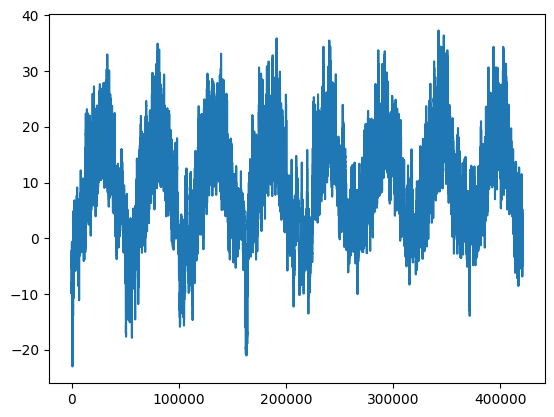

In [3]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperatura (en grados celsius)
plt.plot(range(len(temp)), temp)
plt.show()

En este gráfico se puede ver claramente la periodicidad anual de la temperatura.

Aquí hay un gráfico más refinado de los primeros diez días de datos de temperatura (ya que los datos se registran cada diez minutos, obtenemos 144 puntos de datos por día):

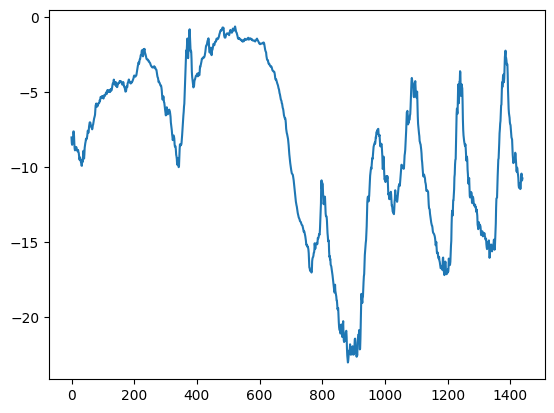

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

En esta gráfica se puede ver la periodicidad diaria, especialmente la de los últimos 4 días. También podemos notar que este período de diez días debe venir de un mes de invierno bastante frío.

Si estuviéramos tratando de predecir la temperatura media para el mes siguiente dados unos pocos datos del pasado, el problema sería fácil, debido a la periodicidad fiable de los datos a escala anual. Pero mirando los datos en una escala de días, la temperatura parece mucho más caótica. Por tanto, ¿son estas series temporales predecibles a escala diaria? Vamos a averiguarlo.

## 3. Preparando los datos

La formulación exacta de nuestro problema será la siguiente: dados los datos que se remontan a `lookback` pasos de tiempo o timesteps (un timestep es de 10 minutos) y muestreado cada `steps` timesteps, ¿podemos predecir la temperatura en `delay` timesteps?

Vamos a usar los siguientes valores de parámetros:

* `lookback = 720`, es decir, nuestras observaciones se remontan a 5 días atrás.
* `steps = 6`, es decir, nuestras observaciones serán muestreadas en un datapoint por hora.
* `delay = 144`, es decir, nuestros objetivos serán de 24 horas en el futuro.

Para empezar, necesitamos hacer dos cosas:

* Preprocesar los datos en un formato que una red neuronal pueda ingerir. Esto es fácil: los datos ya son numéricos, así que no necesitamos hacer ninguna vectorización. Sin embargo, cada serie temporal de los datos está en una escala diferente (por ejemplo, la temperatura suele estar entre -20 y +30, pero la presión, medida en mbar, es de alrededor de 1000). Así que vamos a normalizar cada serie temporal de forma independiente para que todos ellos tomen pequeños valores en un escala similar.
* Escribir un generador que tome nuestro conjunto actual de datos de tipo float y produzca batches de datos del pasado reciente, junto con una temperatura objetivo en el futuro. Dado que las muestras en nuestro conjunto de datos son altamente redundantes (por ejemplo, la muestra `N` y la muestra `N + 1` tendrán la mayoría de sus timesteps en común), sería muy derrochador asignar explícitamente cada muestra. En lugar de eso, generaremos las muestras sobre la marcha usando los datos originales.

Preprocesamos los datos restando la media de cada serie temporal y dividiéndola por la desviación estándar. Planeamos usar los primeros 200.000 pasos de tiempo como datos de entrenamiento, por lo que calculamos la media y la desviación estándar sólo en esta fracción de los datos:

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Vamos a hacer el generador mediante un Dataset personalizado, de tal manera que durante el entrenamiento, se vayan generando ejemplos. A continuación vamos a hacer nuestro generador de datos, que produce una tupla `(samples, targets)` donde `samples` es un lote de datos de entrada y `targets` es el conjunto correspondiente de temperaturas objetivo. Se necesitan los siguientes argumentos:

* `data`: La matriz original de datos en coma flotante, que acabamos de normalizar en el fragmento de código anterior.
* `lookback`: Cuántos timesteps hacia atrás deben ir nuestros datos de entrada.
* `delay`: Cuántos timesteps en el futuro debería ser nuestro objetivo
* `min_index` y `max_index`: Índices en la matriz de `datos` que delimitan los timesteps a seguir. Esto será utilizado para separar un segmento de los datos para la entrenamiento, otro para validación y otro para las pruebas.
* `shuffle`: Ya sea para barajar nuestras muestras o dibujarlas en orden cronológico.
* `batch_size`: El número de muestras por lote.
* `step`: El período, en timesteps, en el que se muestrean los datos. Lo fijaremos en 6 para poder dibujar un punto de datos cada hora (los datos fueron tomados cada 10 minutos).

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback, step, delay, min_index, max_index):
        self.data = torch.FloatTensor(data)
        self.lookback = lookback
        self.step = step
        self.delay = delay
        self.min_index = min_index
        
        if max_index is None: # Calculamos un máximo si no nos dan uno
            max_index = len(data) - delay - 1
        self.max_index = max_index
        
        # Número de muestras disponibles dado el lookback y delay
        self.num_samples = (self.max_index - self.min_index - self.lookback)

    def __len__(self):
        return max(0, self.num_samples)

    def __getitem__(self, idx):
        # Índice absoluto en el array original. Es decir, la muestra empieza ahí
        current_idx = self.min_index + idx
        
        # Ventana de entrada: desde current_idx hasta current_idx + lookback, saltando 'step'
        indices = range(current_idx, current_idx + self.lookback, self.step)
        x = self.data[indices]
        
        # Objetivo: temperatura (columna 1) en el futuro
        # El momento de predicción es el final de la ventana + delay
        target_idx = current_idx + self.lookback + self.delay - 1
        y = self.data[target_idx, 1] # Solo predecimos Temperatura (columna 1)
        
        return x, y

Ahora usemos nuestro dataset para instanciar tres generadores, uno para entrenamiento, otro para validación y otro para pruebas. 
Cada uno de ellos examinará diferentes segmentos temporales de los datos originales: el generador para training examina los primeros 200.000 pasos de tiempo, el generador para validation mira a los siguientes 100.000, y el generador para test mira al resto.

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

# Definimos los rangos para Train, Validation y Test
train_dataset = TimeSeriesDataset(float_data, lookback, step, delay, min_index=0, max_index=200000)
val_dataset = TimeSeriesDataset(float_data, lookback, step, delay, min_index=200001, max_index=300000)
test_dataset = TimeSeriesDataset(float_data, lookback, step, delay, min_index=300001, max_index=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batches de entrenamiento: {len(train_loader)}")

Batches de entrenamiento: 1552


## 4. Una base de sentido común, no de machine learning

Antes de que empecemos a aprovechar los modelos de aprendizaje profundo como caja negra para resolver nuestro problema de predicción de temperatura, probemos un enfoque simple de sentido común. Servirá como un sanity check, y establecerá una base que tendremos que batir para demostrar la utilidad de los modelos más avanzados de aprendizaje automático. Estas líneas de base de sentido común pueden ser muy útiles cuando se aborda un nuevo problema para el que no existe una solución conocida (todavía). Un ejemplo clásico es el de las tareas de clasificación desequilibradas, donde algunas clases pueden ser mucho más comunes que otras. Si su conjunto de datos contiene el 90% de las instancias de clase A y el 10% de las instancias de clase B, entonces un enfoque de sentido común para la tarea de clasificación sería predecir siempre "A" cuando se presenta con una nueva muestra. Dicho clasificador tendría una precisión general del 90%, y, por lo tanto, cualquier enfoque basado en el aprendizaje automático debería superar esta puntuación del 90% para demostrar su utilidad. A veces una base tan elemental puede resultar sorprendentemente difícil de superar.

En nuestro caso, se puede suponer con seguridad que las series temporales de temperatura son continuas (las temperaturas de mañana probablemente se aproximen a las temperaturas de hoy), así como periódicos con un período diario. Por lo tanto, un enfoque de sentido común sería predecir siempre que la temperatura 24 horas a partir de ahora será igual a la temperatura actual. Evaluemos este enfoque, utilizando la métrica del error medio absoluto (MAE). 

El error medio absoluto (MAE) es simplemente igual a `np.mean(np.abs(preds - targets))`

Aquí nuestro bucle de evaluación:

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for samples, targets in val_loader:
        preds = samples[:, -1, 1] # la predicción es la última temperatura
        mae = torch.mean(torch.abs(preds - targets.squeeze()))
        batch_maes.append(mae)
        break
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.30405432


Se obtiene un MAE de 0,30. Dado que nuestros datos de temperatura se han normalizado para que se centren en 0 y tengan una desviación estándar de uno, este número no es inmediatamente interpretable. Esto se traduce en un error absoluto medio de `0,30 * temperature_std` grados centígrados, es decir, unos 2,6˚C. Ese es un error absoluto promedio bastante grande -- ahora el juego es aprovechar nuestro conocimiento de aprendizaje profundo para hacerlo mejor. 

## 5. Una aproximación básica de machine learning

De la misma manera que es útil establecer una base de sentido común antes de intentar los enfoques de aprendizaje automático, es útil intentar modelos de machine learning simples y ligeros (como pequeñas redes densamente conectadas) antes de examinar más complicados y computacionalmente costosos, como las RNN. Esta es la mejor manera de asegurarnos de que cualquier complejidad adicional que lancemos al problema más adelante sea legítima y ofrezca beneficios reales.

Vamos a probar un modelo completamente conectado en el que empezamos aplanando los datos y luego los ejecutamos a través de dos capas `Linear`. Usamos el MAE como pérdida. Ya que estamos evaluando con los mismos datos y con la misma métrica que con nuestro enfoque de sentido común, los resultados serán directamente comparables.

In [9]:
import torch.nn as nn
import torch.optim as optim
import auxiliar as aux

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLPModel(nn.Module):
    def __init__(self, input_length, features):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_length * features, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x) 
        x = self.fc1(x) 
        x = torch.relu(x)
        x = self.fc2(x)       
        return x   

def train_model(model, train_loader, val_loader, epochs=20):
    criterion = nn.L1Loss() # MAE
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)

    history = {'loss': [], 'val_loss': []}
    for epoch in range(epochs):
        # --- Fase de Entrenamiento ---
        model.train() 
        loss_acum = 0            
        for x, y in train_loader:
            # Enviamos los datos la GPU.
            x, y = x.to(device), y.to(device) # <-- Enviamos datos a la GPU
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds.squeeze(), y)
            loss.backward()
            optimizer.step()
            # calculamos métricas
            loss_acum += loss.item()
            avg_train_loss = loss_acum / len(train_loader) 

        # --- Fase de Evaluación ---
        model.eval() 
        loss_acum = 0
        with torch.no_grad(): 
            for x, y in val_loader:
                # Enviamos los datos la GPU. Y aprovechamos para convertir
                # la etiqueta a float (por defecto, ImageFolder devuelve int64 para las labels)
                x, y = x.to(device), y.to(device) # <-- Enviamos datos a la GPU
                preds = model(x)
                loss = criterion(preds.squeeze(), y)
                loss_acum += loss.item()
        avg_val_loss = loss_acum / len(val_loader)        
        print(f"Epoch [{epoch:02d}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        history['loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
    return history



In [10]:
model = MLPModel(lookback // step,float_data.shape[-1]).to(device)

train_model(model, train_loader, val_loader, epochs=10)

Epoch [00/10], Train Loss: 0.2492, Validation Loss: 0.3325
Epoch [01/10], Train Loss: 0.1872, Validation Loss: 0.3471
Epoch [02/10], Train Loss: 0.1658, Validation Loss: 0.3477
Epoch [03/10], Train Loss: 0.1512, Validation Loss: 0.3510
Epoch [04/10], Train Loss: 0.1450, Validation Loss: 0.3677
Epoch [05/10], Train Loss: 0.1381, Validation Loss: 0.3648
Epoch [06/10], Train Loss: 0.1330, Validation Loss: 0.3597
Epoch [07/10], Train Loss: 0.1272, Validation Loss: 0.3686
Epoch [08/10], Train Loss: 0.1242, Validation Loss: 0.3688
Epoch [09/10], Train Loss: 0.1201, Validation Loss: 0.3711


{'loss': [0.24920036897216877,
  0.18722229361649334,
  0.16583867724408807,
  0.15123778153882966,
  0.1450006569706902,
  0.13805486644935056,
  0.132972730822938,
  0.127157584951288,
  0.12422214226662806,
  0.12006724044949431],
 'val_loss': [0.3324618568813259,
  0.3471078887049641,
  0.3477316917537095,
  0.3509692204269496,
  0.3676888682044946,
  0.36477508906807216,
  0.35973902289550025,
  0.36859354846082726,
  0.3687706996674662,
  0.3711229191294738]}

Podemos ver que en algunas épocas, la pérdida sobre validación se acerca a la base sin aprendizaje, pero no llega a mejorar y por tanto, no son muy fiables. Esto demuestra el mérito de haber tenido esta base en primer lugar: resulta no ser tan fácil de superar. Nuestro sentido común ya contiene mucha información valiosa a la que un modelo de machine learning no tiene acceso.

Te podrías estar preguntado, si existe un modelo simple y de buen desempeño para pasar de los datos a los objetivos (nuestra base de sentido común), ¿por qué el modelo que estamos entrenando no lo encuentra y lo mejora? En pocas palabras: porque esta sencilla solución no es lo que nuestra configuración de entrenamiento está buscando. El espacio de los modelos en los que buscamos una solución, es decir, nuestro espacio de hipótesis, es el espacio de todas las redes de dos capas posibles. Con la configuración que hemos definido. Estas redes ya son bastante complicadas. En la búsqueda de una solución con un espacio de modelos complicados, la simple base con buen desempeño podría ser inaprendible, incluso si es técnicamente parte del espacio de hipótesis. Esto es una **limitación bastante significativa del aprendizaje automático en general**: *a menos que el algoritmo de aprendizaje esté codificado para buscar una clase específica de un modelo simple, el aprendizaje de parámetros puede a veces no encontrar una solución simple a un problema simple*.


## 6. Una primera base recurrente

Nuestro primer enfoque MLP no funcionó muy bien, pero eso no significa que el aprendizaje automático no sea aplicable a nuestro problema. El enfoque anterior consistió en aplanar primero las series temporales, lo que eliminó la noción de tiempo de los datos de entrada. En su lugar, miremos nuestros datos como lo que son: una secuencia, donde la causalidad y el orden importan. Intentaremos un modelo de procesamiento de secuencias recurrente -- debería ser el modelo perfecto para tales datos secuenciales, precisamente porque explota el ordenamiento temporal de los puntos de datos, a diferencia de nuestro primer enfoque.

En lugar de la capa `LSTM` introducida en la práctica anterior, utilizaremos la capa `GRU`, desarrollada por Cho et al. en 2014. Las capas de `GRU` (que significa "gated recurrent unit") funcionan aprovechando el mismo principio que LSTM, pero están un poco racionalizadas y por lo tanto son más baratas de ejecutar, aunque puede que no tengan tanto poder de representación como las LSTM. Este compromiso entre la costosidad computacional y el poder de representación se ve en todas partes en el aprendizaje automático.

In [26]:
class ClimateGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0):
        super(ClimateGRU, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Definición de la capa GRU
        # batch_first=True espera tensores de forma (batch, seq, feature)
        self.gru = nn.GRU(
            input_dim, 
            hidden_dim, 
            num_layers=num_layers,  # lo usaremos para apilar capas GRU más adelante
            dropout=dropout if num_layers > 1 else 0,   # lo usaremos para hacer dropout más adelante
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        
        # Capa lineal final para la regresión
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        
        # Forward pass de la GRU
        # out contiene las salidas de todos los pasos temporales
        # hn contiene el estado oculto del último paso
        out, hn = self.gru(x)
        
        # Tomamos la salida del último paso temporal para predecir
        # out[:, -1, :] es equivalente a tomar el último hidden state de la última capa
        #last_time_step = out[:, -1, :]
        last_time_step = self.dropout(out[:, -1, :])
               
        prediction = self.fc(last_time_step)
        return prediction

In [13]:
# Si la celda siguiente te da un error de versiones de CUDNN, ejecuta las siguientes líneas y prueba de nuevo:
# import os
# if 'LD_LIBRARY_PATH' in os.environ:
#     del os.environ['LD_LIBRARY_PATH']

In [14]:
input_dim = float_data.shape[1]
hidden_dim = 32

model_simple = ClimateGRU(input_dim, hidden_dim, num_layers=1).to(device)
history_simple = train_model(model_simple, train_loader, val_loader, epochs=10)

Epoch [00/10], Train Loss: 0.2874, Validation Loss: 0.2592
Epoch [01/10], Train Loss: 0.2591, Validation Loss: 0.2644
Epoch [02/10], Train Loss: 0.2393, Validation Loss: 0.2640
Epoch [03/10], Train Loss: 0.2244, Validation Loss: 0.2791
Epoch [04/10], Train Loss: 0.2113, Validation Loss: 0.2951
Epoch [05/10], Train Loss: 0.2000, Validation Loss: 0.2955
Epoch [06/10], Train Loss: 0.1909, Validation Loss: 0.3013
Epoch [07/10], Train Loss: 0.1838, Validation Loss: 0.3080
Epoch [08/10], Train Loss: 0.1782, Validation Loss: 0.3107
Epoch [09/10], Train Loss: 0.1736, Validation Loss: 0.3150


Miremos nuestros resultados:

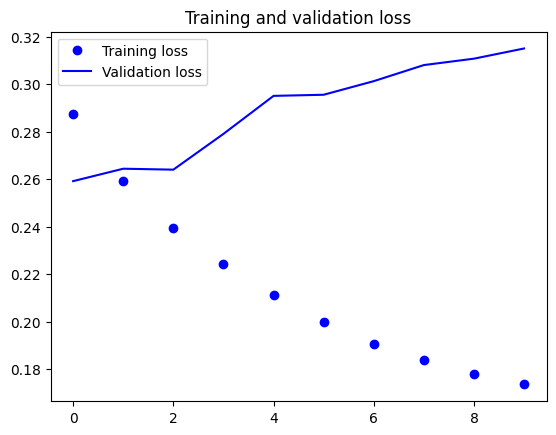

In [15]:
loss = history_simple['loss']
val_loss = history_simple['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

¡Un poco mejor! Somos capaces de superar la base del sentido común si nos quedamos en el punto donde se sobreajusta (sobre la época 3). Esto demuestra el valor del aprendizaje automático, así como la superioridad de las redes recurrentes en comparación con las redes densas que "aplastan" la secuencia en este tipo de tareas.

Nuestra nueva validación MAE de ~0,26 (antes de que comencemos a sobreajustar significativamente) se traduce en un error absoluto medio de 2,35˚C después de la desnormalización. Eso es una sólida ganancia sobre nuestro error inicial de 2,57˚C, pero probablemente todavía tenemos un poco de margen para mejorar.

## 7. Apilando capas recurrentes

El aumento de la capacidad de la red se realiza normalmente aumentando el número de unidades en las capas o añadiendo más capas. El apilamiento de capas recurrentes es una forma clásica de construir redes recurrentes más potentes: por ejemplo, las primeras versiones del algoritmo de traducción de Google era una pila de siete capas grandes de LSTM, lo que era enorme.

Para poder apilar capas recurrentes una encima de otra en PyTorch, es suficiente con crear una capa recurrente pasándole en argumento `num_layers`. Por defecto ese argumento es 1, por lo que solo creamos una capa. Pero podemos apilar más aumentando ese número. Por suerte, nuestro modelo ClimateGRU ya lo hicimos para que aceptara como argumento el número de capas a apilar. Este apilamiento se hace internamente usando la salida que contiene la secuencia completa de salidas y pasándoselo a la siguiente.



In [28]:
model_stack = ClimateGRU(input_dim, hidden_dim, num_layers=2).to(device)
history_stack = train_model(model_stack, train_loader, val_loader, epochs=10)

Epoch [00/10], Train Loss: 0.2906, Validation Loss: 0.2615
Epoch [01/10], Train Loss: 0.2582, Validation Loss: 0.2626
Epoch [02/10], Train Loss: 0.2365, Validation Loss: 0.2752
Epoch [03/10], Train Loss: 0.2109, Validation Loss: 0.3069
Epoch [04/10], Train Loss: 0.1878, Validation Loss: 0.3085
Epoch [05/10], Train Loss: 0.1704, Validation Loss: 0.3087
Epoch [06/10], Train Loss: 0.1580, Validation Loss: 0.3163
Epoch [07/10], Train Loss: 0.1489, Validation Loss: 0.3235
Epoch [08/10], Train Loss: 0.1414, Validation Loss: 0.3232
Epoch [09/10], Train Loss: 0.1348, Validation Loss: 0.3279


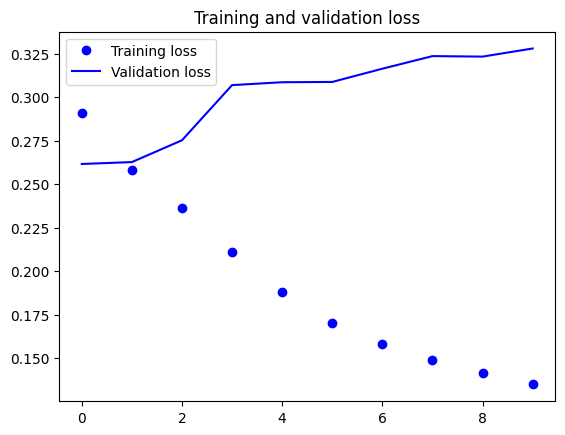

In [29]:
loss = history_stack['loss']
val_loss = history_stack['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 8. Usando dropout para contraatacar al sobreajuste

De nuestras curvas de entrenamiento y validación se deduce que nuestro modelo está sobredimensionado: las pérdidas en entrenamiento y validación empiezan a divergir considerablemente después de unas pocas épocas. Ya estás familiarizado con una técnica clásica para combatir este fenómeno: el **dropout**, que consiste en la puesta a cero aleatoria de las unidades de entrada de una capa para romper las correlaciones de casualidad en los datos de entrenamiento a los que está expuesta la capa. 

Sin embargo, cómo aplicar correctamente el dropout en redes recurrentes no es una cuestión trivial. Se sabe desde hace mucho tiempo que la aplicación del dropout antes de una capa recurrente dificulta el aprendizaje en lugar de ayudar con la regularización. En 2015, Yarin Gal, como parte de su tesis doctoral sobre el aprendizaje profundo bayesiano, determinó la forma correcta de utilizar el dropout con una red recurrente: se debe aplicar la misma máscara de dropout (el mismo patrón de unidades de dropout) en cada paso de tiempo, en lugar de una máscara de dropout que varíe aleatoriamente de un paso de tiempo a otro. Es más: para regularizar las representaciones formadas por las puertas recurrentes de capas como GRU y LSTM, se debe aplicar una máscara de dropout temporal constante a las activaciones internas recurrentes de la capa (una máscara de **dropout "recurrente"**). El uso de la misma máscara de dropout en cada paso del tiempo permite a la red propagar adecuadamente su error de aprendizaje a través del tiempo; en cambio, una máscara de dropout temporal aleatorio interrumpiría esta señal de error y sería perjudicial para el proceso de aprendizaje. Yarin Gal hizo su investigación usando Keras y ayudó a construir este mecanismo directamente en las capas recurrentes de Keras. 

Sin embargo, el dropout recurrente es **muy ineficiente** (rompe por completo la implementación en GPU con CUDNN), y por tanto **en PyTorch no está implementado** de forma nativa (hasta la fecha de creación de esta práctica). A pesar de todo lo anterior, dropout se sigue utilizando de forma directa apilado como una capa después de una recurrente, ya que, en la práctica, tiene un comportamiento similar en la mayoría de casos. De hecho, las capas recurrentes de PyTorch tienen un argumento extra (`dropout`) al que se le puede especificar la tasa de dropout, y lo que hará será meter dropout entre las capas recurrentes que hayamos metido (si `num_layers`>1). 

Vamos a hora a introducir dropout entre las dos capas apiladas, lo cual lo tenemos ya hecho con nuestro `ClimateGRU` (argumento `dropout`). También introduciremos una capa de dropout después de la GRU. Debido a que las redes que se regularizan con dropout siempre tardan más en converger completamente, entrenamos a nuestra red durante el doble de épocas. Este entrenamiento tardará un buen rato.

Si recuerdas la descripción del "flujo de trabajo de aprendizaje automático universal": en general, es una buena idea aumentar la capacidad de tu red hasta que el sobreajuste se convierta en tu principal obstáculo (suponiendo que ya estés tomando medidas básicas para mitigar el sobreajuste, como el uso del dropout). Siempre y cuando no estés sobreajustando demasiado, entonces es probable que estés por debajo de capacidad de abstracción. Puedes probar a añadir otra capa más, cosa que te dejo como ejercicio.



In [27]:
model_dropout = ClimateGRU(input_dim, hidden_dim, num_layers=2, dropout=0.5).to(device)
history_dropout = train_model(model_dropout, train_loader, val_loader, epochs=20)

Epoch [00/20], Train Loss: 0.3387, Validation Loss: 0.2662
Epoch [01/20], Train Loss: 0.3122, Validation Loss: 0.2699
Epoch [02/20], Train Loss: 0.3030, Validation Loss: 0.2613
Epoch [03/20], Train Loss: 0.2968, Validation Loss: 0.2660
Epoch [04/20], Train Loss: 0.2898, Validation Loss: 0.2623
Epoch [05/20], Train Loss: 0.2836, Validation Loss: 0.2712
Epoch [06/20], Train Loss: 0.2767, Validation Loss: 0.2787
Epoch [07/20], Train Loss: 0.2707, Validation Loss: 0.2792
Epoch [08/20], Train Loss: 0.2648, Validation Loss: 0.2890
Epoch [09/20], Train Loss: 0.2597, Validation Loss: 0.2905
Epoch [10/20], Train Loss: 0.2537, Validation Loss: 0.2963
Epoch [11/20], Train Loss: 0.2489, Validation Loss: 0.3111
Epoch [12/20], Train Loss: 0.2448, Validation Loss: 0.3071
Epoch [13/20], Train Loss: 0.2409, Validation Loss: 0.3067
Epoch [14/20], Train Loss: 0.2374, Validation Loss: 0.3106
Epoch [15/20], Train Loss: 0.2341, Validation Loss: 0.3186
Epoch [16/20], Train Loss: 0.2315, Validation Loss: 0.31

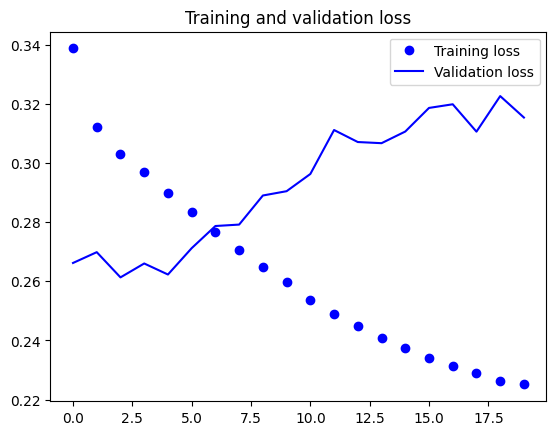

In [30]:
loss = history_dropout['loss']
val_loss = history_dropout['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Ya no estamos sobreajustando durante las primeras 8 épocas. Sin embargo, aunque tenemos puntuaciones de evaluación más estables, nuestras mejores puntuaciones no son mucho más bajas de lo que eran antes.


Podemos observar que las capas añadidas mejoran nuestros resultados un poco, aunque no muy significativamente. Podemos obtener dos conclusiones de esto:

* Dado que aún no estamos sobreajustando demasiado, podemos incrementar con seguridad el tamaño de nuestras capas para buscar un poco de mejora en la pérdida de validación. Sin embargo, esto conyeva un aumento del coste computacional.
* Daado que añadir una capa no ayuda significativamente, es posible que en este punto estemos viendo una disminución de los beneficios del aumento de la capacidad de la red. 

## 9. RNNs bidireccionales

La última técnica que comentaremos en esta práctica se llama "RNNs bidireccionales". Una RNN bidireccional es una variante común de RNN que puede ofrecer un mayor rendimiento que una RNN normal en determinadas tareas. Se utiliza con frecuencia en el procesamiento del lenguaje natural (PNL) - se podría decir que es la navaja suiza de aprendizaje profundo para el PNL.

Los RNNs son notablemente dependientes del orden, o dependientes del tiempo: procesan los pasos de tiempo de sus secuencias de entrada en orden, y barajando o invirtiendo los pasos de tiempo pueden cambiar completamente las representaciones que el RNN extraerá de la secuencia. Esta es precisamente la razón por la que funcionan bien en problemas donde el orden es significativo, como nuestro problema de pronóstico de temperatura. Una RNN bidireccional explota la sensibilidad del orden de las RNNs: simplemente consiste en dos RNNs regulares, como las capas GRU o LSTM con las que ya estás familiarizado, cada una de las cuales procesa la secuencia de entrada en una dirección (cronológica y anticronológicamente), y luego fusiona sus representaciones. Al procesar una secuencia en ambos sentidos, una RNN bidireccional es capaz de captar patrones que pueden haber sido pasados por alto por una RNN unidireccional.

Para predecir el tiempo, es suficiente procesar en orden cronológico las muestras, por lo que no vamos a utilizar aquí las RNN bidireccionales. Eso sí, en PyTorch es muy sencillo hacerlo, y es usando el argumento booleano `bidirectional`.



## 10. Siguientes pasos

En este punto, todavía hay muchas otras cosas que podrías intentar para mejorar el rendimiento de nuestro problema de pronóstico del tiempo:

* Ajusta el número de unidades en cada capa recurrente en la configuración apilada. Las opciones actuales son en gran medida arbitrarias y, por lo tanto, probablemente subóptimas.
* Ajusta la velocidad de aprendizaje utilizando como optimizador `RMSprop`.
* Intenta usar capas de `LSTM` en lugar de capas de `GRU`.
* Intenta usar un regresor densamente conectado más grande encima de las capas recurrentes, es decir, una capa `Dense` más grande o incluso una pila de capas `Dense`.
* No te olvides de ejecutar eventualmente los modelos de mejor rendimiento (en términos de validación MAE) en el conjunto de prueba. Empieza al menos a desarrollar arquitecturas que se sobreajusten al conjunto de validación.   

Como de costumbre: el aprendizaje profundo es más un arte que una ciencia, y aunque podemos proporcionar directrices sobre lo que es probable que funcione o no en un problema dado, en última instancia cada problema es único y tendrás que tratar de evaluar diferentes estrategias empíricamente. Actualmente no hay ninguna teoría que nos diga de antemano con precisión lo que debe hacer uno para resolver un problema de forma óptima. Debes probar e iterar.


## 11. Concluyendo

Esto es lo que deberías haber aprendido en esta práctica:

* Al abordar un nuevo problema, es bueno establecer primero bases de sentido común como referencia métrica de tu elección. Si no tienes una base que batir, no puedes decir si estás haciendo algún progreso real.
* Prueba modelos sencillos antes que los costosos, para justificar el gasto adicional. A veces un modelo simple resultará ser tu mejor opción.
* En los datos en los que el ordenamiento temporal es importante, las redes recurrentes encajan perfectamente y superan fácilmente a los modelos que primero aplastan los datos temporales.
* Para utilizar dropout con redes recurrentes, se debería utilizar una máscara de tiempo constante y una máscara de dropout recurrente. Lo primero está incorporado en las capas recurrentes de PyTorch, por lo que no suele hacer falta acudir al dropout recurrente.
* Las RNNs apiladas proporcionan más poder de representación que una sola capa de RNN, pero sobreajustan más. También son mucho más costosos y, por lo tanto, no siempre valen la pena. Si bien ofrecen claras ventajas sobre problemas complejos (por ejemplo, la traducción automática), es posible que no siempre sean relevantes para problemas más pequeños y sencillos.
* Los RNNs bidireccionales, que miran una secuencia en ambos sentidos, son muy útiles en problemas de procesamiento de lenguaje natural. Sin embargo, no tendrán un buen desempeño en los datos de series temporales, donde el pasado reciente es mucho más informativo que el comienzo de la secuencia.

Hay dos conceptos importantes que no trataremos en detalle aquí: la "atención" recurrente y el enmascaramiento de secuencias. Ambos tienden a ser especialmente relevantes para el procesamiento del lenguaje natural, y no son particularmente aplicables a nuestro problema de pronóstico de temperatura.